In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional


In [4]:

# Load dataset
df = pd.read_csv('question4-stock-data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [5]:

# Handling missing values
df.fillna(method='ffill', inplace=True)


<ipython-input-5-54285ab024f5>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:

# Feature Engineering
# Adding Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()


In [7]:

# Adding Volatility
df['Volatility'] = df['Close'].rolling(window=10).std()


In [8]:

# Adding Momentum
df['Momentum'] = df['Close'] - df['Close'].shift(4)


In [9]:

# Adding Lag Features
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)


In [10]:

# Drop rows with NaN values (created by rolling windows and lag features)
df.dropna(inplace=True)


In [11]:

# Feature selection
features = ['Close', 'MA_10', 'MA_50', 'Volatility', 'Momentum', 'Close_lag1', 'Close_lag2']
data = df[features].values


In [12]:

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


In [13]:

# Create sequences for LSTM
def create_sequences(data, time_steps=30, future_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:(i + time_steps), :])  # Use all features
        y.append(data[i + time_steps + future_steps - 1, 0])  # Predict 'Close' price 5 days into the future
    return np.array(X), np.array(y)

time_steps = 30  # Use 30 days of historical data
future_steps = 5  # Predict 5 days into the future
X, y = create_sequences(data_scaled, time_steps, future_steps)


In [14]:

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:

# LSTM Model with Bidirectional Layers
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(time_steps, len(features))),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 4.9448e-04 - val_loss: 0.0026
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.6075e-04 - val_loss: 6.0269e-04
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.7796e-04 - val_loss: 6.1155e-04
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.5375e-04 - val_loss: 0.0018
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.4748e-04 - val_loss: 5.1417e-04
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.4069e-04 - val_loss: 5.0401e-04
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.1347e-04 - val_loss: 5.0206e-04
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.1128e-04 - val_loss: 0.0015
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.5054e-04 - val_loss: 0.0015
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.3271e-04

In [17]:

# Predictions
y_pred = model.predict(X_test)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [18]:

# Inverse transform predictions and actual values
# Create a dummy array to inverse transform
dummy_array_pred = np.zeros((len(y_pred), len(features)))
dummy_array_pred[:, 0] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(dummy_array_pred)[:, 0]

dummy_array_test = np.zeros((len(y_test), len(features)))
dummy_array_test[:, 0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(dummy_array_test)[:, 0]


In [19]:

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse}')


RMSE: 5.67941820537868


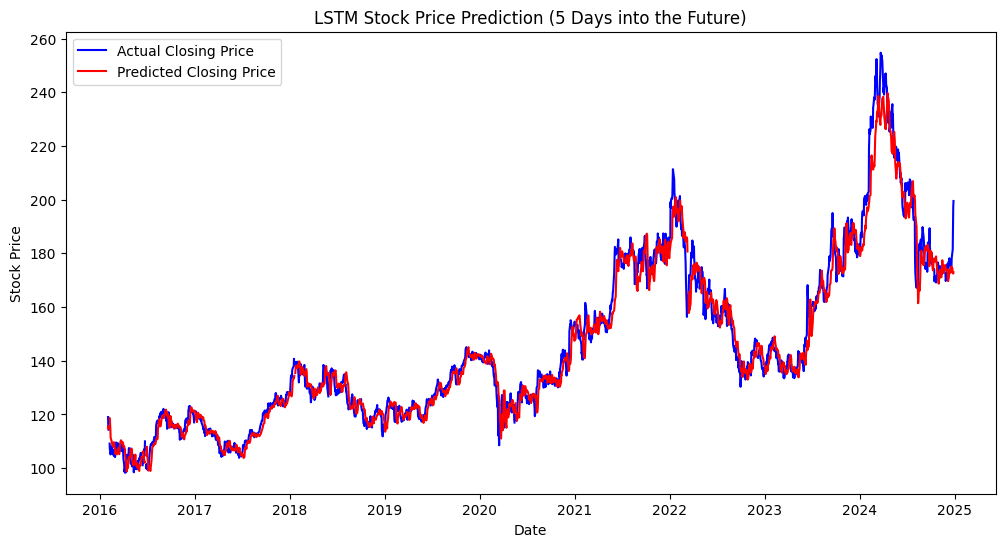

In [20]:

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Closing Price', color='blue')
plt.plot(df.index[-len(y_test):], y_pred_inv, label='Predicted Closing Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('LSTM Stock Price Prediction (5 Days into the Future)')
plt.legend()
plt.show()


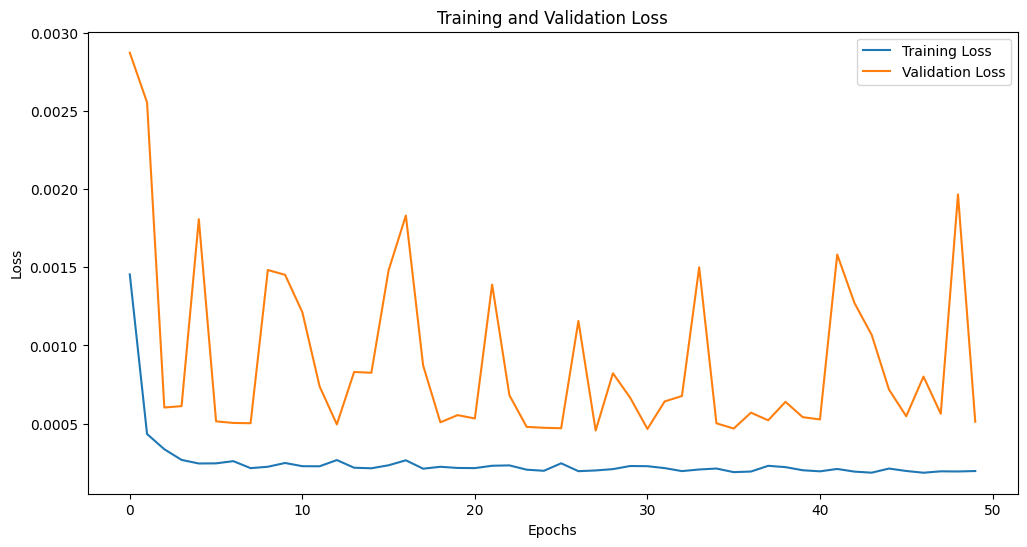

In [21]:

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


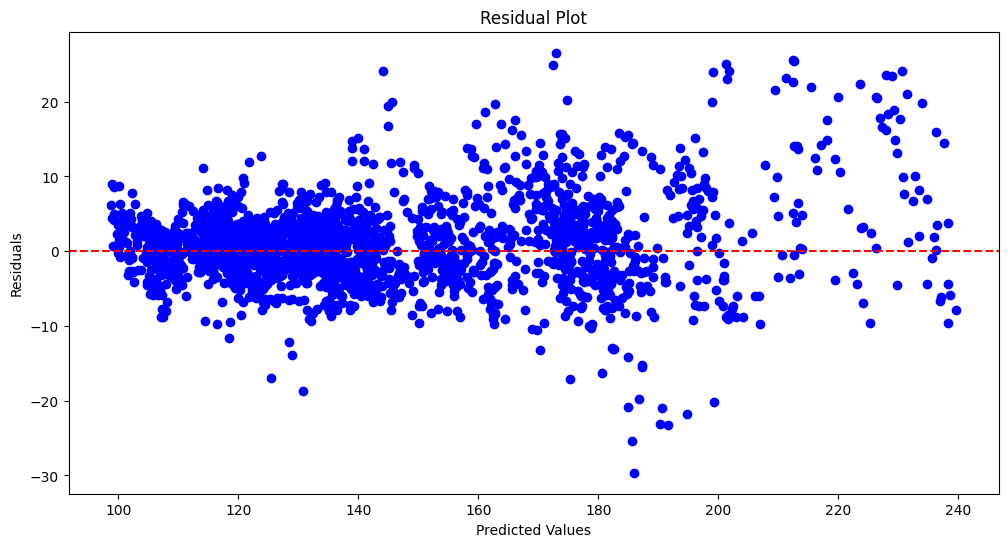

In [22]:

# Residual Plot
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_inv, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


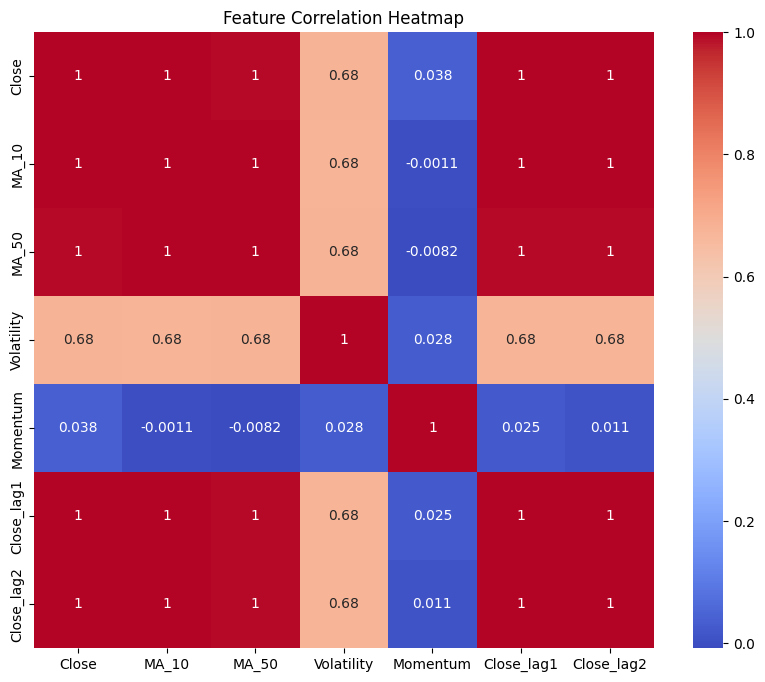

In [23]:

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [24]:

# Save predictions
df_pred = pd.DataFrame({'Date': df.index[-len(y_test):], 'Actual': y_test_inv, 'Predicted': y_pred_inv})
df_pred.to_csv('predictions.csv', index=False)
print('Predictions saved as predictions.csv')

Predictions saved as predictions.csv
